# EAGLE vs.  TokenCut: Unsupervised Segmentation Comparison

This notebook compares two unsupervised vision methods on the **COCO-Stuff** dataset:

1.  **EAGLE**: Unsupervised Semantic Segmentation (27 classes)
2.  **TokenCut**: Unsupervised Object Discovery (Binary: Foreground vs Background)

**Goal**: Evaluate both methods on a common task: **Binary Object Segmentation** (Thing vs. Stuff).

**Metrics**:
*   **Binary mIoU**: Intersection over Union for Foreground/Background separation.

---

## Step 1: Environment Setup
Install dependencies and clone repositories.

In [1]:
# Install dependencies
!pip install -q torch torchvision pytorch-lightning==1.9.0 omegaconf hydra-core scipy scikit-learn matplotlib seaborn tqdm wget gdown kmeans-pytorch

import os
import sys
import shutil
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F

# Define Paths
EAGLE_ROOT = Path("/content/EAGLE")
DATA_ROOT = Path("/content/data/cocostuff164k")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print("Environment setup complete")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.4 MB/s eta 0:00:00
Environment setup complete


## Step 2: Download & Prepare EAGLE
Clone the EAGLE repository

In [2]:
# Clone EAGLE
if EAGLE_ROOT.exists():
    shutil.rmtree(EAGLE_ROOT)
!git clone https://github.com/MICV-yonsei/EAGLE.git {EAGLE_ROOT}

# Apply PyTorch Compatibility Fixes
os.chdir(EAGLE_ROOT / "src_EAGLE")

utils_path = EAGLE_ROOT / "src_EAGLE" / "utils.py"
content = utils_path.read_text()
content = content.replace("from torch._six import string_classes", "string_classes = (str, bytes)")

if "from torch.utils.data._utils.collate import" in content:
    content = content.replace(
        "from torch.utils.data._utils.collate import np_str_obj_array_pattern, default_collate_err_msg_format",
        "# Compatibility fix\nimport re\nnp_str_obj_array_pattern = re.compile(r'[SaUO]')\ndefault_collate_err_msg_format = 'default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found {}'"
    )
utils_path.write_text(content)

train_path = EAGLE_ROOT / "src_EAGLE" / "train_segmentation_eigen.py"
train_content = train_path.read_text()
train_content = train_content.replace(
    "from pytorch_lightning.utilities.seed import seed_everything",
    "from pytorch_lightning import seed_everything"
)
train_path.write_text(train_content)

# Add to path
sys.path.insert(0, str(EAGLE_ROOT / "src_EAGLE"))

print("EAGLE setup and patched")

Cloning into '/content/EAGLE'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 90 (delta 25), reused 31 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 9.23 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (25/25), done.
EAGLE setup and patched


## Step 3: Dataset Setup (COCO-Stuff)
Upload `val2017.zip` and `stuffthingmaps_trainval2017.zip` to `/content/data/cocostuff164k/` or use Google Drive.

In [3]:
# Step 3: Download from Shared Google Drive Link
import gdown
import zipfile
import os

files_to_download = {
    "val2017.zip": "1fcOYoY16zH23K2jO7B3dPwGbobZY3TEe",
    "stuffthingmaps_trainval2017.zip": "1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1"
}

os.chdir(DATA_ROOT)

for filename, file_id in files_to_download.items():
    if not (DATA_ROOT / filename).exists():
        print(f"Downloading {filename}...")
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, filename, quiet=False)

    # Extract
    if "val2017" in filename and not (DATA_ROOT / "images" / "val2017").exists():
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(str(DATA_ROOT / "images"))
    elif "stuffthingmaps" in filename and not (DATA_ROOT / "annotations" / "val2017").exists():
        print(f"Extracting {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(str(DATA_ROOT / "annotations"))

    print(f"{filename} ready")

# Setup Directory Structure for EAGLE
(DATA_ROOT / "cocostuff" / "curated" / "val2017").mkdir(parents=True, exist_ok=True)
val_images = sorted([f.stem for f in (DATA_ROOT / "images" / "val2017").glob("*.jpg")])
with open(DATA_ROOT / "cocostuff" / "curated" / "val2017" / "Coco164kFull_Stuff_Coarse_7.txt", 'w') as f:
    f.write("\n".join(val_images))

if not (DATA_ROOT / "cocostuff" / "images").exists():
    os.symlink(DATA_ROOT / "images", DATA_ROOT / "cocostuff" / "images")
if not (DATA_ROOT / "cocostuff" / "annotations").exists():
    os.symlink(DATA_ROOT / "annotations", DATA_ROOT / "cocostuff" / "annotations")

print(f"Dataset ready: {len(val_images)} images")

Downloading...
From (original): https://drive.google.com/uc?id=1fcOYoY16zH23K2jO7B3dPwGbobZY3TEe
From (redirected): https://drive.google.com/uc?id=1fcOYoY16zH23K2jO7B3dPwGbobZY3TEe&confirm=t&uuid=e051f508-fe20-4e21-8a2c-6fa194882ada
To: /content/data/cocostuff164k/val2017.zip
100%|██████████| 816M/816M [00:11<00:00, 68.5MB/s]


Extracting val2017.zip...
val2017.zip ready


Downloading...
From (original): https://drive.google.com/uc?id=1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1
From (redirected): https://drive.google.com/uc?id=1r9sjFsQazgaqpu8SMMKzZqeJY5hQleV1&confirm=t&uuid=66a8c48b-c51c-4a6a-8de5-78dc93752113
To: /content/data/cocostuff164k/stuffthingmaps_trainval2017.zip
100%|██████████| 659M/659M [00:06<00:00, 106MB/s] 


Extracting stuffthingmaps_trainval2017.zip...
stuffthingmaps_trainval2017.zip ready
Dataset ready: 5000 images


## Step 4: Load Models
1.  **EAGLE**: Load pre-trained checkpoint.
2.  **TokenCut**: We implement TokenCut logic using the DINO backbone.

In [4]:
# Download EAGLE Pre-trained Model
import gdown
pretrained_dir = EAGLE_ROOT / "pretrained"
pretrained_dir.mkdir(exist_ok=True)
ckpt_path = pretrained_dir / "eagle_cocostuff_pretrained.ckpt"

if not ckpt_path.exists():
    print("Downloading EAGLE checkpoint...")
    # Using Google Drive Link
    file_id = "1fRZB_Tx2cZn5XayY0MiC9gv6D9kML7lh"
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(ckpt_path), quiet=False)

# Load EAGLE
from train_segmentation_eigen import LitUnsupervisedSegmenter
from utils import get_transform
from data import ContrastiveSegDataset
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)

cfg = checkpoint['hyper_parameters']['cfg']
cfg.pytorch_data_dir = str(DATA_ROOT)

model = LitUnsupervisedSegmenter(27, cfg).to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print("EAGLE Model Loaded")

# TokenCut Implementation (Spectral Clustering on DINO)
def run_tokencut(img_tensor, model):
    with torch.no_grad():
        # Use EAGLE's DINO backbone
        _, _, _, features = model.net(img_tensor.unsqueeze(0))
        B, C, H, W = features.shape

        # Flatten & Normalize
        features = features.view(C, -1).permute(1, 0)
        features = F.normalize(features, dim=1, p=2)

        # Affinity Matrix
        A = features @ features.T
        A = torch.clamp(A, min=0)

        # N-Cut / Eigendecomposition
        D = A.sum(dim=1)
        D_inv_sqrt = torch.pow(D, -0.5)
        D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0
        L = D_inv_sqrt.unsqueeze(0) * A * D_inv_sqrt.unsqueeze(1)

        try:
            _, eigenvectors = torch.lobpcg(L, k=2, largest=True)
            eigvec = eigenvectors[:, 0]
        except:
            eigvals, eigvecs = torch.linalg.eigh(L)
            eigvec = eigvecs[:, -2]

        eigvec = eigvec.view(H, W)
        eigvec = F.interpolate(eigvec.unsqueeze(0).unsqueeze(0), size=img_tensor.shape[-2:], mode='bilinear', align_corners=False).squeeze()

        # Binarize (Mean Threshold)
        binary_mask = (eigvec > eigvec.mean()).float().cpu().numpy()

        # Center Bias Heuristic
        if binary_mask[binary_mask.shape[0]//2, binary_mask.shape[1]//2] == 0:
            binary_mask = 1 - binary_mask

        return binary_mask

print("TokenCut Function Ready")

Downloading...
From (original): https://drive.google.com/uc?id=1fRZB_Tx2cZn5XayY0MiC9gv6D9kML7lh
From (redirected): https://drive.google.com/uc?id=1fRZB_Tx2cZn5XayY0MiC9gv6D9kML7lh&confirm=t&uuid=d6302723-1c60-4321-bc7c-d4337509c4e9
To: /content/EAGLE/pretrained/eagle_cocostuff_pretrained.ckpt
100%|██████████| 123M/123M [00:00<00:00, 127MB/s]


Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 342MB/s]


EAGLE Model Loaded
TokenCut Function Ready


## Step 5: Binary Evaluation (Thing vs. Stuff)
We define "Thing" classes (foreground) and evaluate both models on Binary IoU.

In [5]:
# Define "Thing" Classes in COCO-Stuff-27 (Foreground)
THING_CLASSES = [0, 1, 2, 3, 6, 7, 9, 10, 11, 18]

def compute_iou(pred, target):
    intersection = np.logical_and(pred, target).sum()
    union = np.logical_or(pred, target).sum()
    return intersection / (union + 1e-6)

# Setup Dataset
val_dataset = ContrastiveSegDataset(
    pytorch_data_dir=str(DATA_ROOT),
    dataset_name="cocostuff27",
    crop_type=None,
    image_set="val",
    transform=get_transform(320, False, "center"),
    target_transform=get_transform(320, True, "center"),
    mask=True,
    cfg=cfg,
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# Evaluation Loop
eagle_ious = []
tokencut_ious = []
num_eval = 500

print(f"Evaluating on {num_eval} images...")

with torch.no_grad():
    for i, batch in enumerate(tqdm(val_loader, total=num_eval)):
        if i >= num_eval: break

        img = batch["img"].to(device)
        label = batch["label"].squeeze().cpu().numpy()

        # 1. Ground Truth Binary Mask
        gt_binary = np.isin(label, THING_CLASSES).astype(float)
        if gt_binary.sum() == 0: continue

        # 2. EAGLE Prediction
        feats, feats_kk, code, code_kk = model.net(img)
        code_kk = F.interpolate(code_kk, (320, 320), mode='bilinear', align_corners=False)

        # Use linear_probe instead of cluster_probe
        # Linear probe maps features to actual class IDs (0=Electronic, 9=Person, etc.)
        linear_preds = model.linear_probe(code_kk)
        eagle_pred = linear_preds.argmax(1).cpu().squeeze().numpy()
        eagle_binary = np.isin(eagle_pred, THING_CLASSES).astype(float)

        # 3. TokenCut Prediction
        tokencut_binary = run_tokencut(img.squeeze(0), model)

        # Compute IoU
        eagle_ious.append(compute_iou(eagle_binary, gt_binary))
        tokencut_ious.append(compute_iou(tokencut_binary, gt_binary))

print("\n" + "="*40)
print("BINARY OBJECT SEGMENTATION RESULTS")
print("="*40)
print(f"EAGLE Binary mIoU:    {np.mean(eagle_ious)*100:.2f}%")
print(f"TokenCut Binary mIoU: {np.mean(tokencut_ious)*100:.2f}%")
print("="*40)

Evaluating on 500 images...


100%|██████████| 500/500 [01:33<00:00,  5.33it/s]


BINARY OBJECT SEGMENTATION RESULTS
EAGLE Binary mIoU:    62.03%
TokenCut Binary mIoU: 31.75%


## Step 6: Qualitative Visualization
Visualize the results side-by-side.

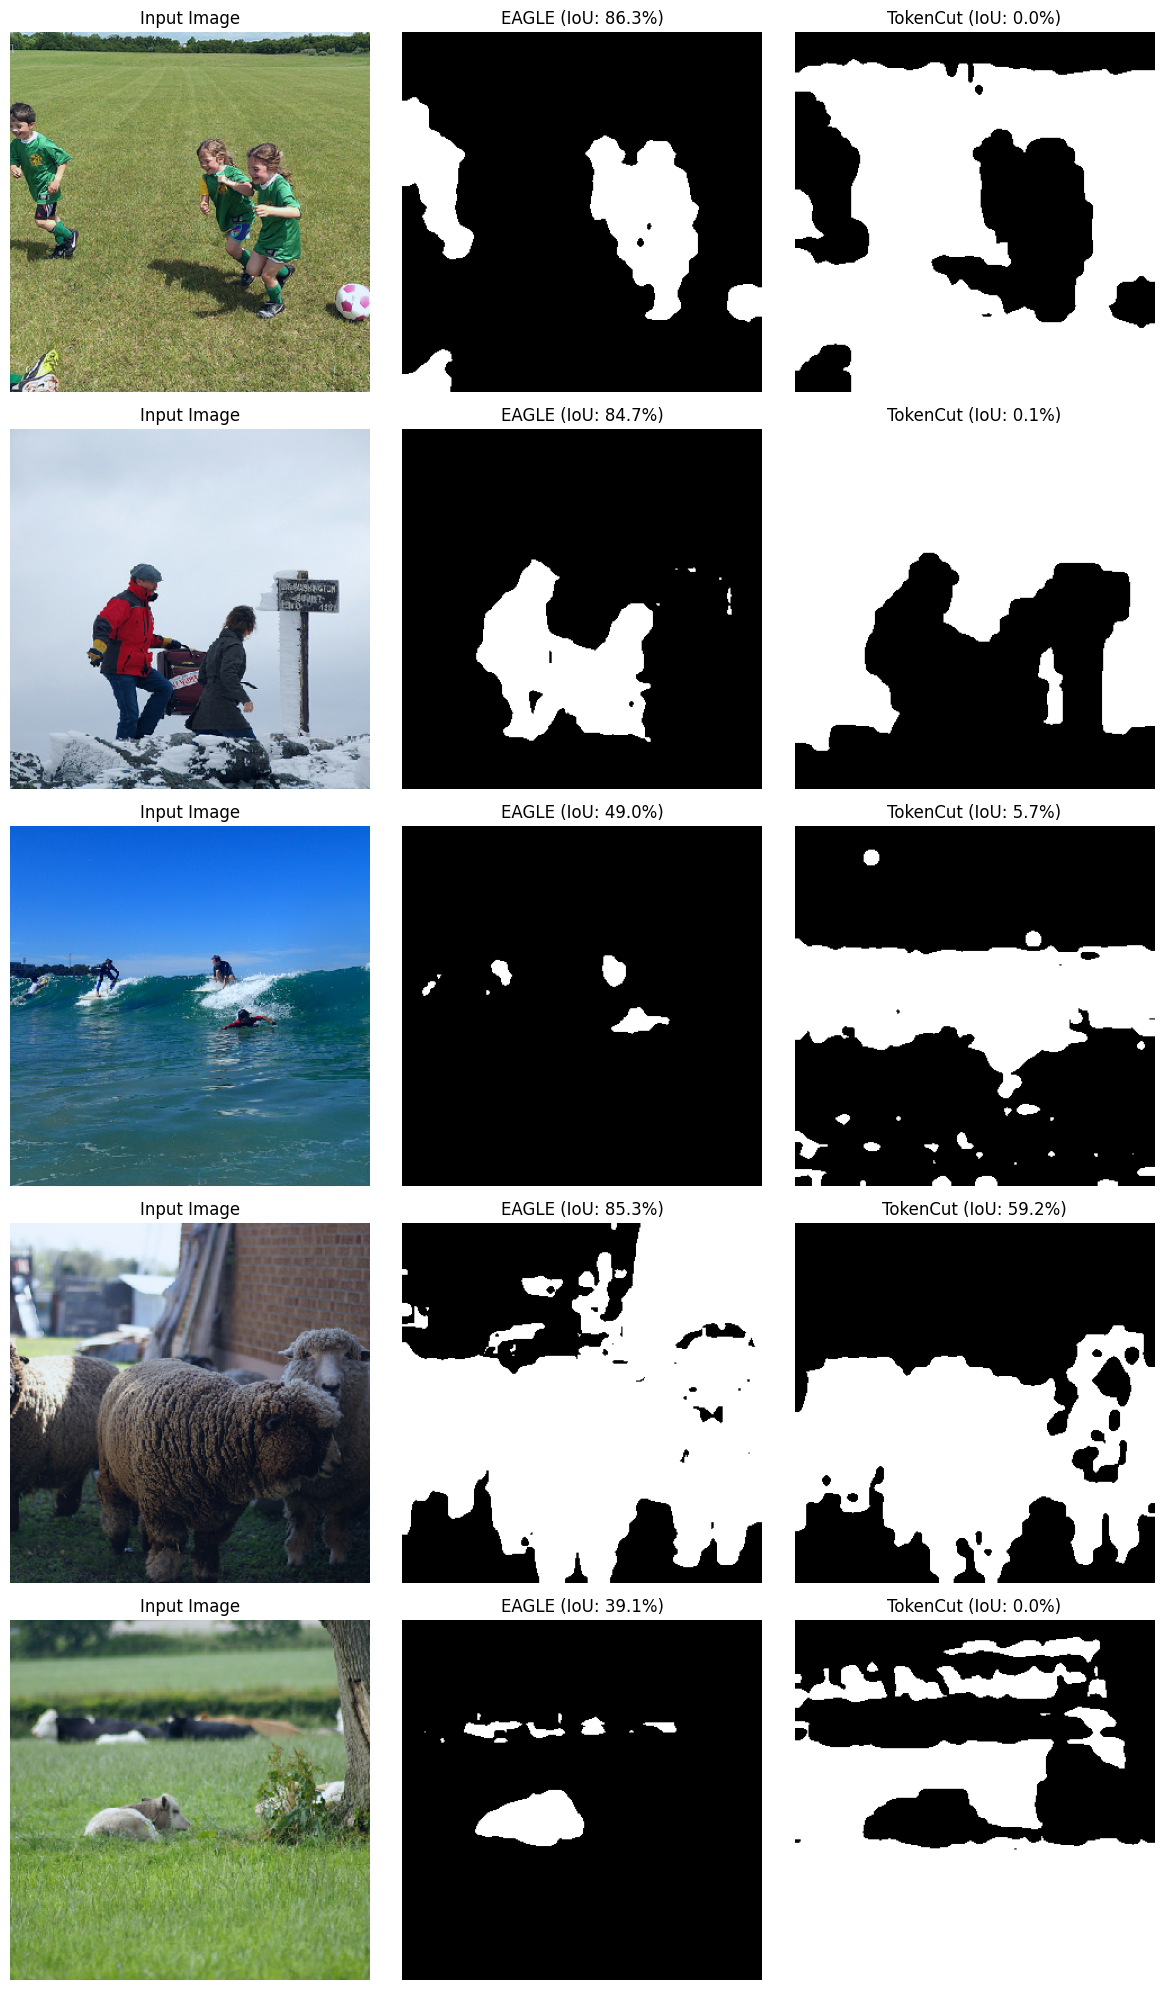

In [6]:
indices = [3852, 1829, 2560, 56, 232]
fig, axes = plt.subplots(len(indices), 3, figsize=(12, 4*len(indices)))

with torch.no_grad():
    for idx, img_idx in enumerate(indices):
        sample = val_dataset[img_idx]
        img = sample["img"].to(device)
        label = sample["label"].squeeze().cpu().numpy()

        # Predictions
        feats, feats_kk, code, code_kk = model.net(img.unsqueeze(0))
        code_kk = F.interpolate(code_kk, (320, 320), mode='bilinear', align_corners=False)

        # Use linear_probe
        linear_preds = model.linear_probe(code_kk)
        eagle_pred = linear_preds.argmax(1).cpu().squeeze().numpy()
        eagle_binary = np.isin(eagle_pred, THING_CLASSES).astype(float)

        tokencut_binary = run_tokencut(img, model)

        # GT Binary (for IoU calculation only)
        gt_binary = np.isin(label, THING_CLASSES).astype(float)

        # Compute IoU for display
        eagle_iou = compute_iou(eagle_binary, gt_binary)
        tokencut_iou = compute_iou(tokencut_binary, gt_binary)

        # Plot
        img_np = img.cpu().permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(eagle_binary, cmap='gray')
        axes[idx, 1].set_title(f"EAGLE (IoU: {eagle_iou*100:.1f}%)")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(tokencut_binary, cmap='gray')
        axes[idx, 2].set_title(f"TokenCut (IoU: {tokencut_iou*100:.1f}%)")
        axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig("eagle_vs_tokencut_comparison.png")
plt.show()

Step 7: Visualizing Real-world Images


Upload your custom images (JPG/PNG)
You can upload multiple images at once



Saving car-road.jpg to car-road.jpg
Saving pedestrians.jpg to pedestrians.jpg
Saving animal-drinking.jpeg to animal-drinking.jpeg
Saving dog-grass.jpg to dog-grass.jpg
Saving football-player.jpg to football-player.jpg

Processing 5 images...



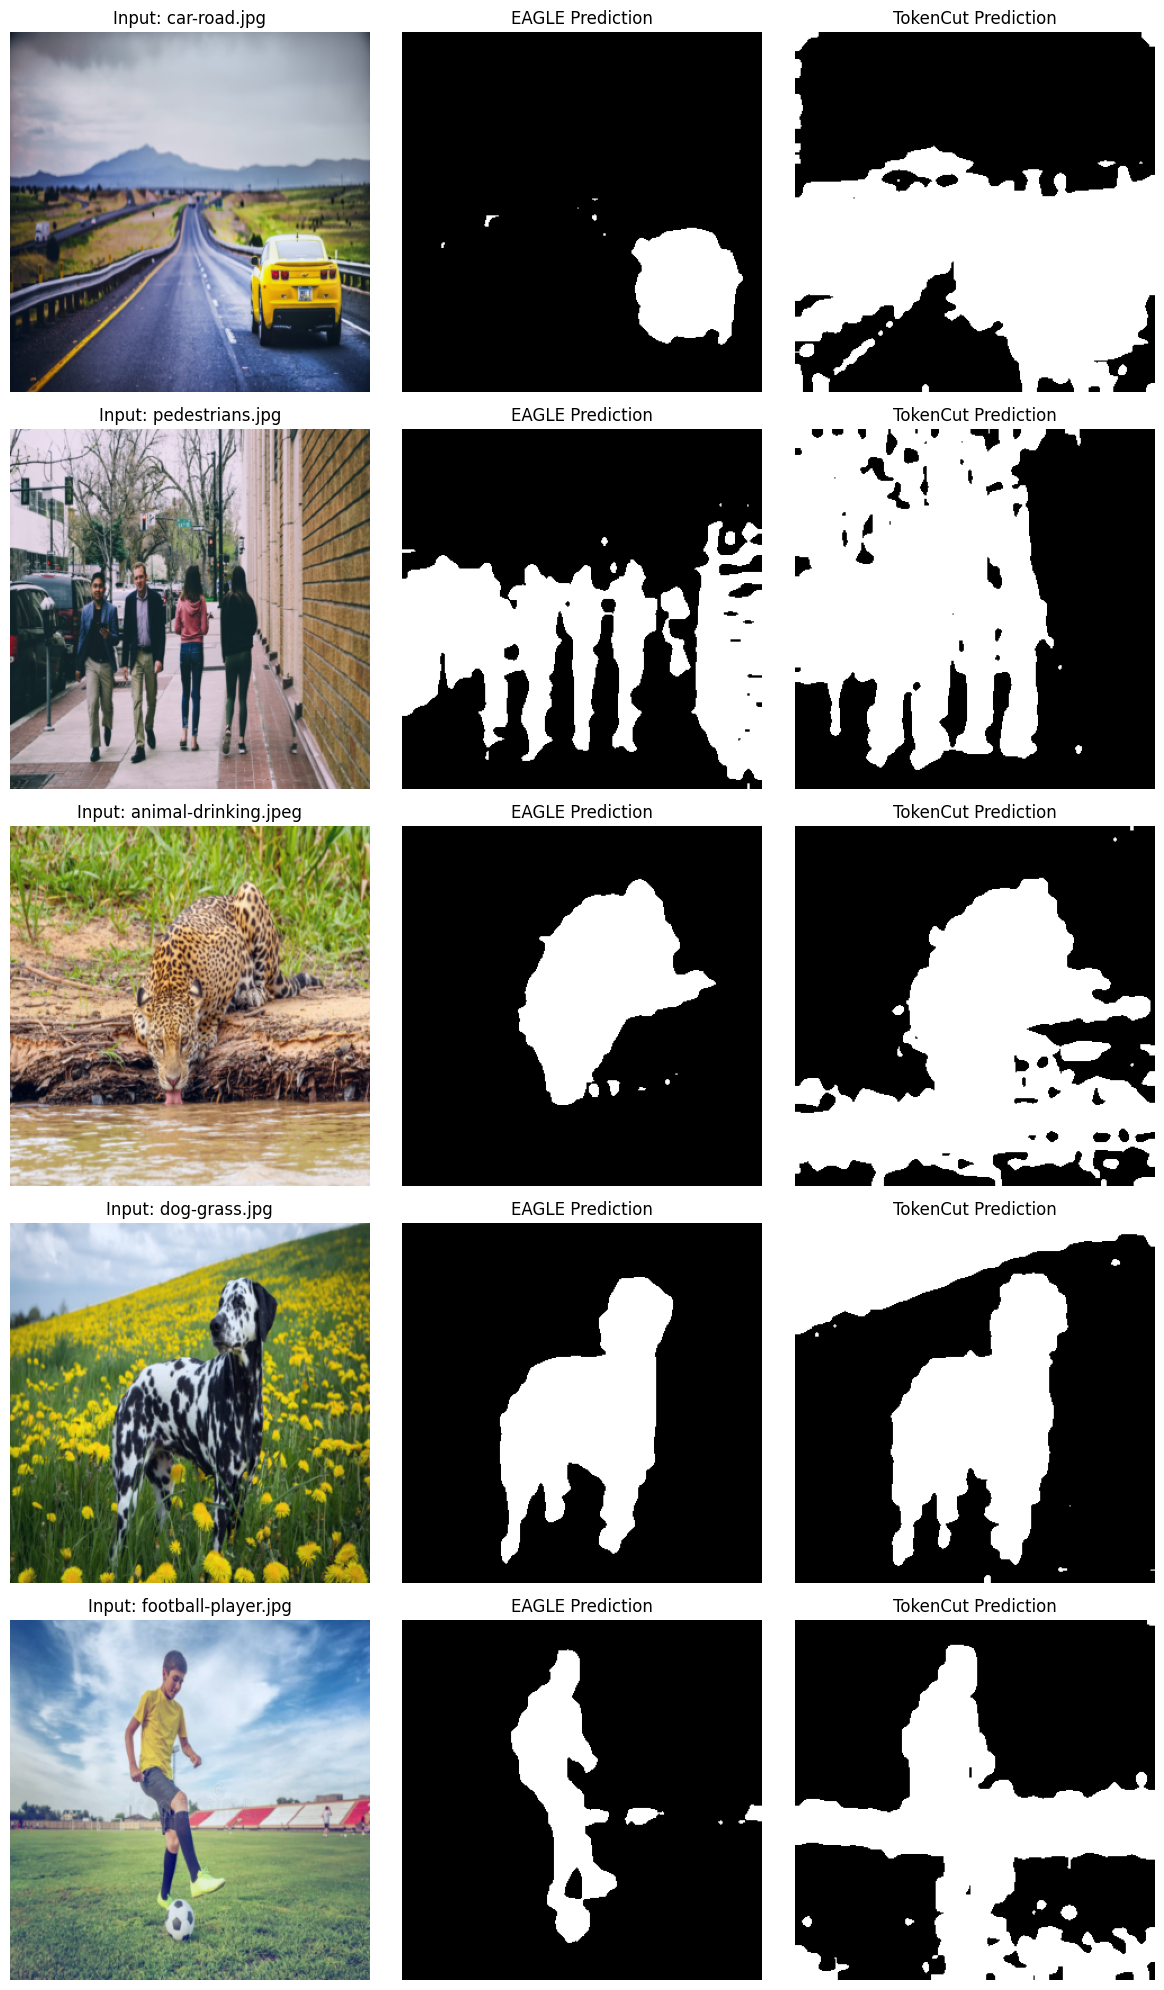


Processing complete!


In [7]:
# Step 7: Upload and Test on Custom Images

from google.colab import files
import io

print("Upload your custom images (JPG/PNG)")
print("You can upload multiple images at once\n")

uploaded = files.upload()

# Process images directly from memory
from torchvision import transforms
from PIL import Image

# Define transform
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(f"\nProcessing {len(uploaded)} images...\n")

# Visualize results
fig, axes = plt.subplots(len(uploaded), 3, figsize=(12, 4*len(uploaded)))

# Handle single image case
if len(uploaded) == 1:
    axes = axes.reshape(1, -1)

with torch.no_grad():
    for idx, (filename, data) in enumerate(uploaded.items()):
        # Load image directly from bytes
        img_pil = Image.open(io.BytesIO(data)).convert('RGB')
        img_tensor = transform(img_pil).to(device)

        # EAGLE Prediction
        feats, feats_kk, code, code_kk = model.net(img_tensor.unsqueeze(0))
        code_kk = F.interpolate(code_kk, (320, 320), mode='bilinear', align_corners=False)

        linear_preds = model.linear_probe(code_kk)
        eagle_pred = linear_preds.argmax(1).cpu().squeeze().numpy()
        eagle_binary = np.isin(eagle_pred, THING_CLASSES).astype(float)

        # TokenCut Prediction
        tokencut_binary = run_tokencut(img_tensor, model)

        # Plot
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f"Input: {filename}")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(eagle_binary, cmap='gray')
        axes[idx, 1].set_title("EAGLE Prediction")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(tokencut_binary, cmap='gray')
        axes[idx, 2].set_title("TokenCut Prediction")
        axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nProcessing complete!")